# 6.6 Sourcing & Analyzing Time Series Data

## Contents: 

1. Import Libraries
2. Import Data
3. Subsetting, Wrangling, and Cleaning Time-Series Data
4. Time Series Analysis: Decomposition
5. Testing for Stationarity

## 1. Import Libraries

In [678]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [679]:
# configure API key 

quandl.ApiConfig.api_key = 'fHXS6Lxja_TyHckzZfJS'

## 2. Import Data

In [681]:
# import datasets

path = r'/Users/analazarevska/Documents/CAREER FOUNDRY/Data Analytics Program/Data Immersion/A6, Advanced Analythics & Dashboard Design/Achievement 6/09-2024 SA Road Crash Analysis'
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'merged_df_dt.csv'))

## 3. Subsetting, Wrangling, and Cleaning Time-Series Data

In [683]:
# remove max column restriction

pd.options.display.max_columns = None

In [684]:
df.head()

,Unnamed: 0,REPORT_ID,crash_stats_area,crash_suburb,crash_postcode,total_units,total_casualties,total_fatalities,total_serious_injuries,total_minor_injuries,crash_month,crash_day,crash_time,area_speed,moisture_conditions,weather_conditions,crash_time_of_day,unit_responsible,dui_involved,drugs_involved,accloc_x,accloc_y,crash_date_time,unit_type,unit_registration_year,unit_controller_sex,unit_controller_age,unit_controller_licence_type,unit_number_of_occupants
0,0,2019-1-16/08/2024,2 Metropolitan,Hampstead Gardens,5086,2,0,0,0,0,June,Wednesday,11:15 am,60,Dry,Not Raining,Daylight,1,N,N,1331810.03,1676603.26,12/6/2019 11:15:00,Station Wagon,1998.0,Female,85.0,Full,1.0
1,1,2019-2-16/08/2024,2 Metropolitan,Dry Creek,5094,2,0,0,0,0,January,Tuesday,12:49 am,90,Dry,Not Raining,Night,2,N,N,1328376.20,1682942.63,1/1/2019 0:49:00,Motor Cars - Sedan,2002.0,Female,31.0,Full,1.0
2,2,2019-3-16/08/2024,2 Metropolitan,Mile End,5031,2,1,0,0,1,January,Tuesday,12:00 am,60,Dry,Not Raining,Night,1,N,N,1325819.68,1670994.26,1/1/2019 0:00:00,Motor Vehicle - Type Unknown,1937.0,Unknown,33.0,Unknown,1.0
3,3,2019-4-16/08/2024,2 Metropolitan,Paralowie,5108,2,1,0,1,0,January,Tuesday,12:05 am,50,Dry,Not Raining,Night,1,N,N,1328320.60,1690237.08,1/1/2019 0:05:00,Motor Cycle,2015.0,Male,21.0,Learners,1.0
4,4,2019-5-16/08/2024,2 Metropolitan,Mount Barker,5251,2,0,0,0,0,January,Tuesday,05:15 am,110,Dry,Not Raining,Night,2,N,N,1353279.99,1655645.15,1/1/2019 5:15:00,NaN,NaN,NaN,NaN,NaN,NaN


In [685]:
# create subset of the data, keeping Date as index and count of crashes for each day as values in another column

# select the needed column

df_selected = df[['crash_date_time']]

# change the date format

df_selected['crash_date_time'] = pd.to_datetime(df_selected['crash_date_time'], format='%d/%m/%Y %H:%M:%S')

# extract the date part

df_selected['crash_date_time'] = df_selected['crash_date_time'].dt.strftime('%Y-%m')

# change the column name

df_selected = df_selected.rename(columns={'crash_date_time': 'crash_date'})

# make column with count of crash_date values

df_selected['crash_date_count'] = df_selected.groupby('crash_date')['crash_date'].transform('count')

# remove duplicate rows

df_selected = df_selected.drop_duplicates(subset='crash_date')

# set the index

df_inx = df_selected.set_index('crash_date')

In [686]:
df_inx.head()

,crash_date_count
crash_date,
2019-06,1096
2019-01,948
2019-02,1035
2019-12,985
2019-05,1262


In [687]:
# sort the index values by date

df_inx = df_inx.sort_index()

In [688]:
df_inx.shape

(60, 1)

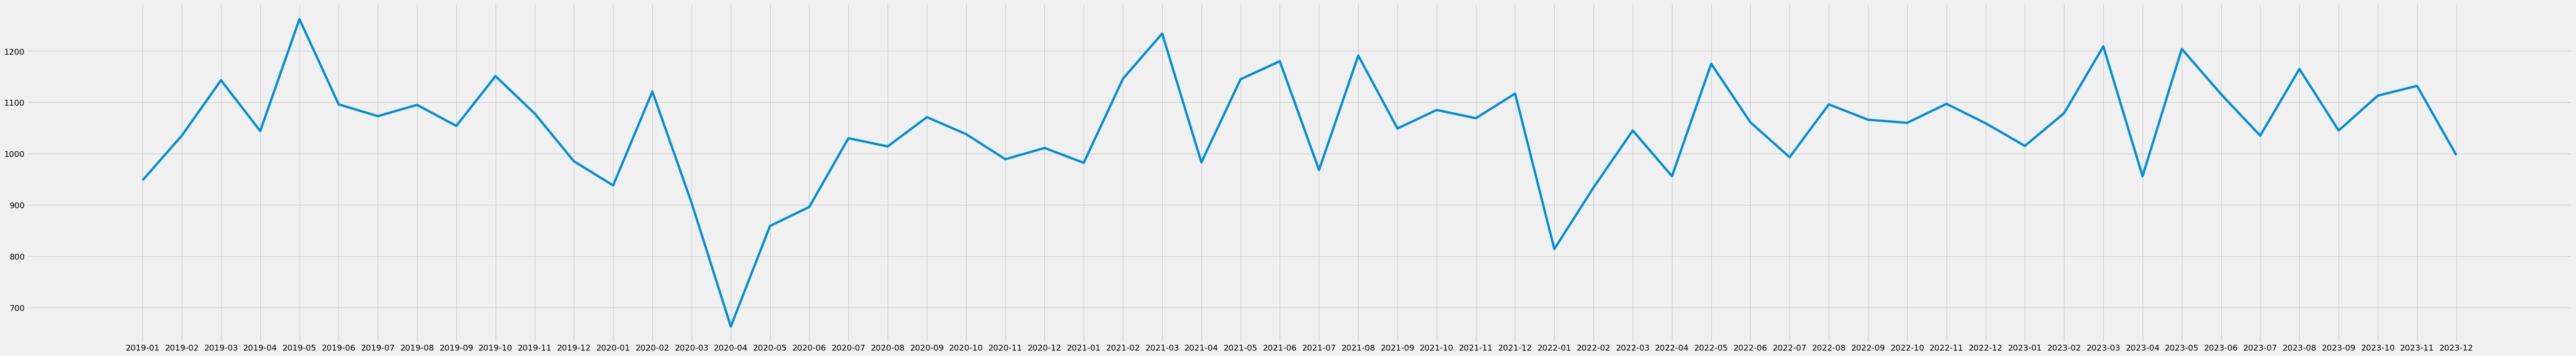

In [690]:
# create line chart of the subset

plt.figure(figsize=(70,10), dpi=100)
plt.plot(df_inx)

## 4. Time Series Analysis: Decomposition


In [692]:
# change the format of the date column to include day

df_inx.index = df_inx.index + '-01'

In [693]:
df_inx.head()

,crash_date_count
crash_date,
2019-01-01,948
2019-02-01,1035
2019-03-01,1143
2019-04-01,1044
2019-05-01,1262


In [694]:
# reset index to a column if needed

df_inx = df_inx.reset_index()  

# fix the format of the column

df_inx['crash_date'] = pd.to_datetime(df_inx['crash_date'])

# set the 'crash_date' column as the index

df_inx = df_inx.set_index('crash_date')  

In [695]:
# decompose the time series using an multiplicative model

decomposition = sm.tsa.seasonal_decompose(df_inx, model='multiplicative')

In [696]:
# define a fixed size for all special charts

from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

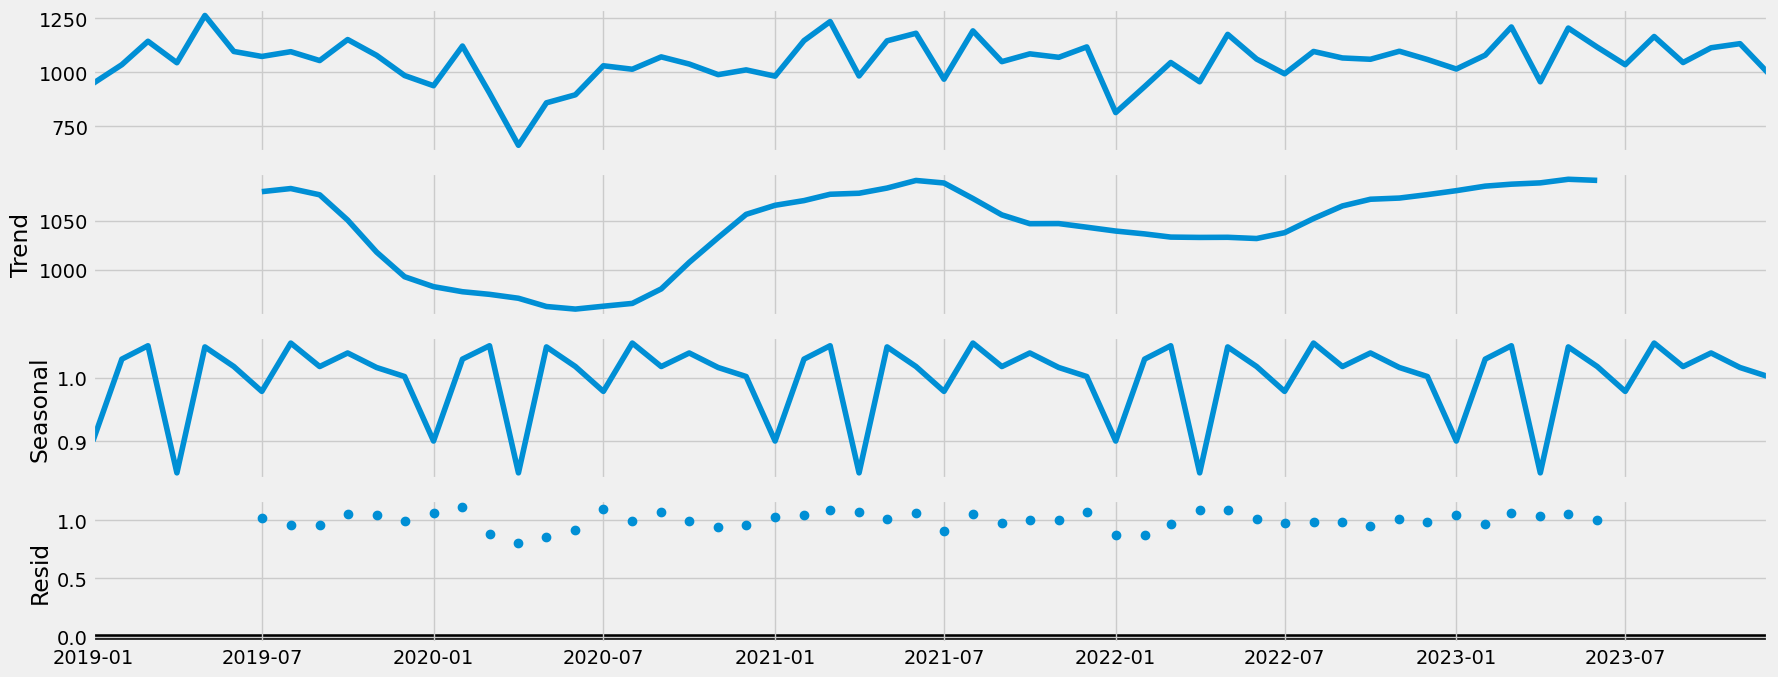

In [697]:
# plot the separate components

decomposition.plot()
plt.show()

In [699]:
# create copy of the subset for smoothing the data

df_inx1 = df_inx.copy()

In [700]:
df_inx1['crash_date_count_smooth'] = df_inx1['crash_date_count'].rolling(window=5).mean()

In [701]:
# drop missing values

df_inx1 = df_inx1.dropna()

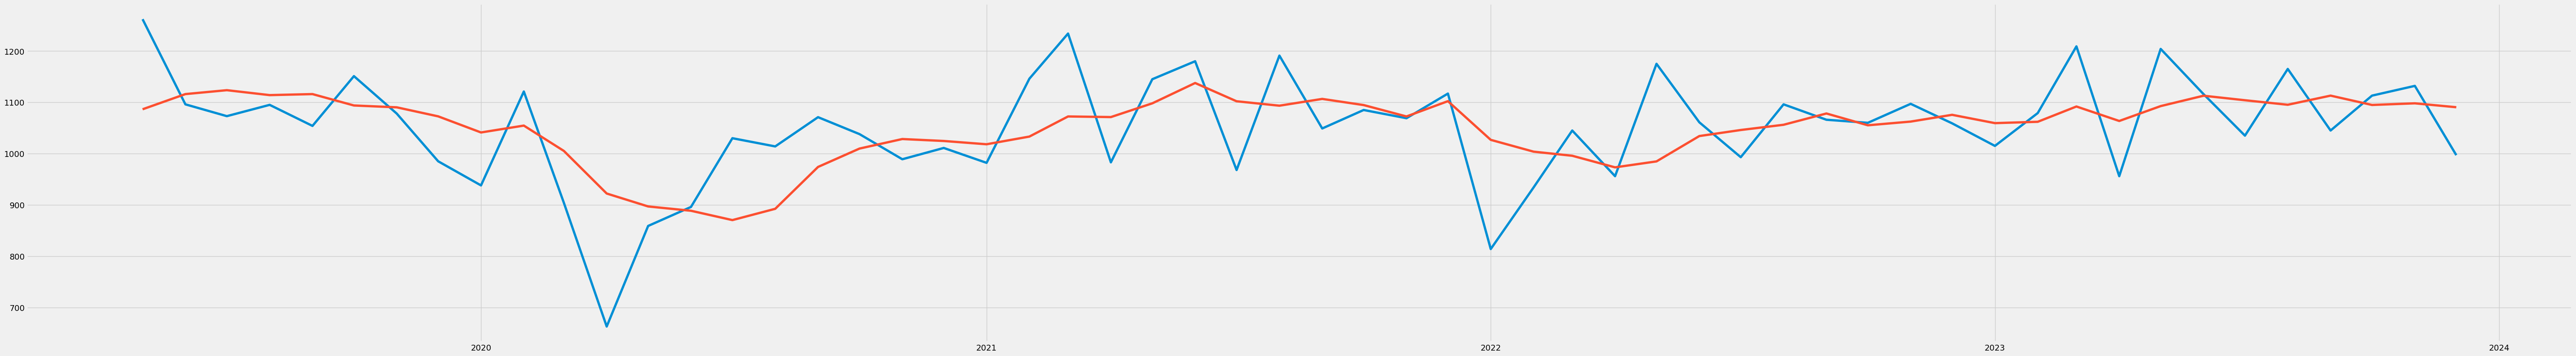

In [702]:
# create line chart of the subset

plt.figure(figsize=(70,10), dpi=100)
plt.plot(df_inx1)

In [703]:
# reset index to a column if needed

df_inx1 = df_inx1.reset_index()  

# fix the format of the column

df_inx1['crash_date'] = pd.to_datetime(df_inx1['crash_date'])

# set the 'crash_date' column as the index

df_inx1 = df_inx1.set_index('crash_date')  

In [704]:
df_inx1 = df_inx1.drop(columns='crash_date_count')

In [705]:
df_inx1.head()

,crash_date_count_smooth
crash_date,
2019-05-01,1086.4
2019-06-01,1116.0
2019-07-01,1123.6
2019-08-01,1114.0
2019-09-01,1116.0


In [706]:
# decompose the time series using an multiplicative model

decomposition1 = sm.tsa.seasonal_decompose(df_inx1, model='multiplicative')

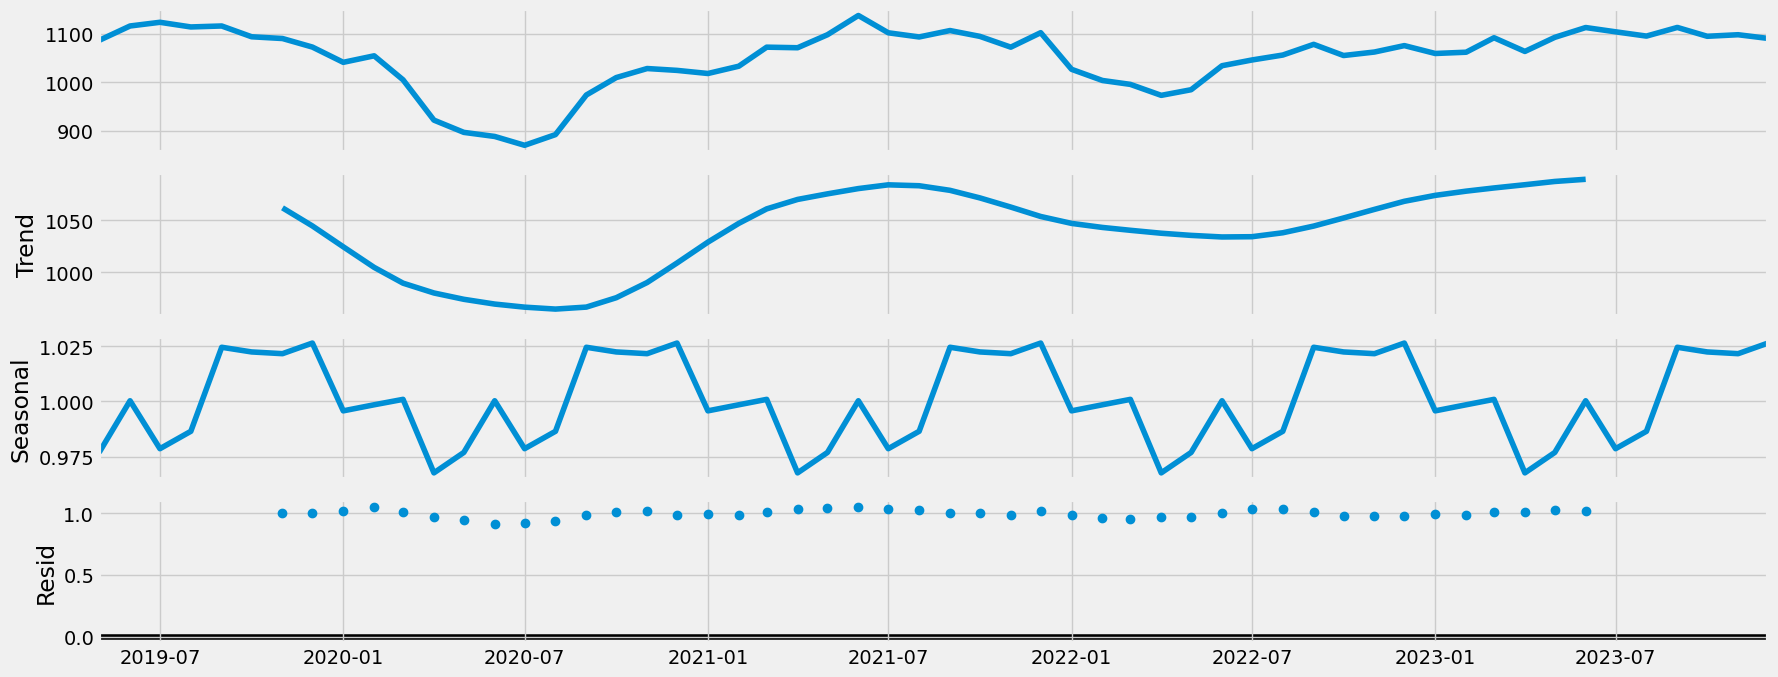

In [707]:
# plot the separate components

decomposition1.plot()
plt.show()

## 5. Testing for Stationarity

In [710]:
# import the adfuller() function

from statsmodels.tsa.stattools import adfuller 

# define the function and perform the Dickey-Fuller test

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# apply the test using the function on the time series

dickey_fuller(df_inx['crash_date_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.135581e+00
p-value                        8.202508e-08
Number of Lags Used            0.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


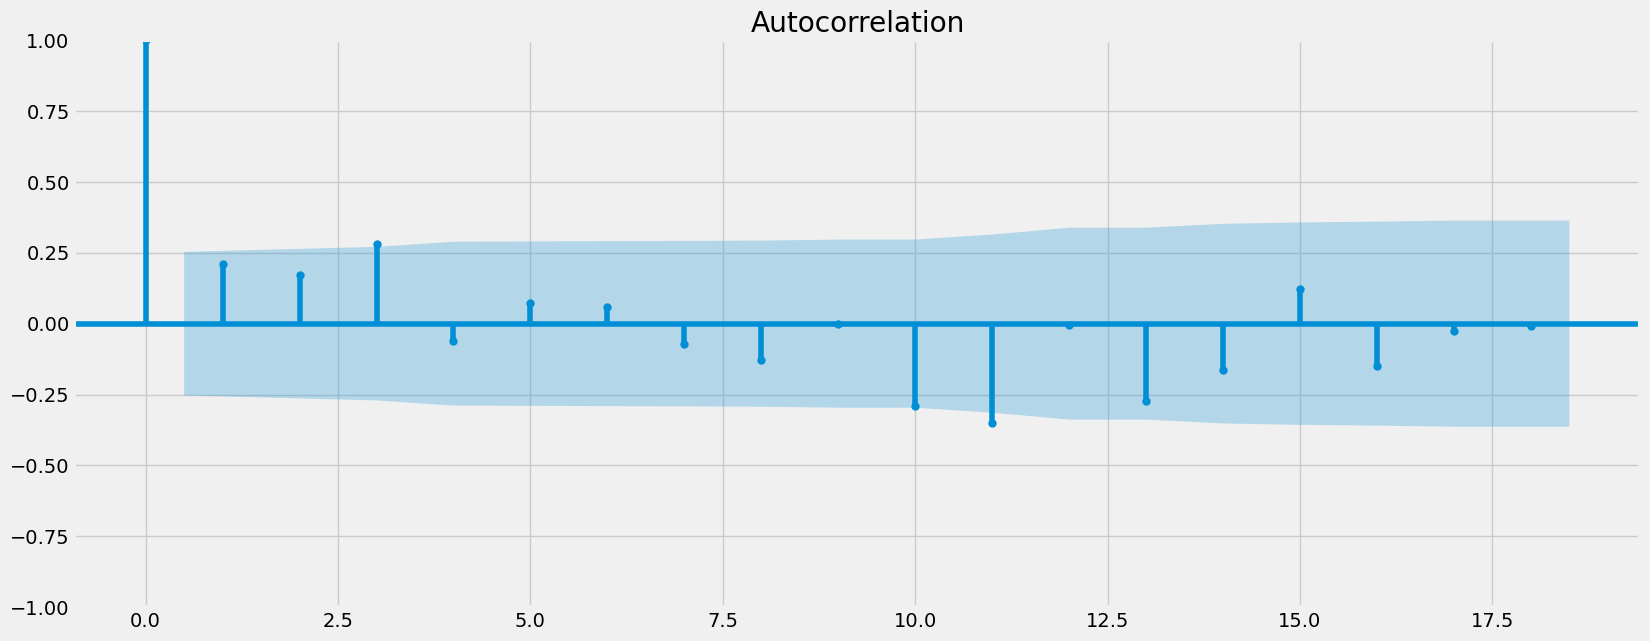

In [711]:
# plot the autocorrelations

# import the autocorrelation and partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_inx)
plt.show()